In [1]:
import numpy as np
from ModelTest import *
import pandas as pd
from Utilities import obsFrac, getMidnightNoonIdx
from SSMTools import *
#from Utilities import ding

In [2]:
colors = 2*[c["color"] for c in plt.rcParams["axes.prop_cycle"]]

In [3]:
df_cleaned = loadAndClean("../output/site_1_cleaned_T.csv", toDrop=['snowdepth_2', 'snowdepth_10', 'Unnamed: 0', 'Unnamed: 0.1', 'datetime'])
for i in range(1, 11):
    df_cleaned.drop('temperature_%i'%i, axis=1, inplace=True)
fullData = df_cleaned.values

In [4]:
df_temp = pd.read_csv("../output/site_1_cleaned_T.csv").drop(['temperature_2', 'temperature_10', 'Unnamed: 0', 'Unnamed: 0.1', 'datetime'], axis=1)
for i in range(1, 11):
    df_temp.drop('snowdepth_%i'%i, axis=1, inplace=True)
tempData = df_temp.values

In [5]:
dateTimes = pd.read_csv("../output/site_1_cleaned_T.csv").drop(['Unnamed: 0', 'Unnamed: 0.1']
                                                               + ["snowdepth_%i"%i for i in range(1, 11)]
                                                               + ["temperature_%i"%i for i in range(1, 11)], axis=1).values.flatten()

In [7]:
genChunkTestSets(fullData, 100, 200, 20, dirName="test_data/intervalLen_200_gapSize_20/")

## Check gap sizes

In [8]:
gapSizes = []

tStart = 4000

for series in fullData.T:
    curGapSizes = []
    
    curGapSize = 0
    # Loop over values in series
    for v in series[tStart:]:
        if np.isnan(v):
            curGapSize = curGapSize + 1
        elif curGapSize > 0:
            # Append current gap size if it's nonzero and a non-nan value was encountered
            gapSizes.append(curGapSize)
            curGapSize = 0
    
# Get total list of gap sizes for the whole dataset
gapSizes = np.asarray(gapSizes)

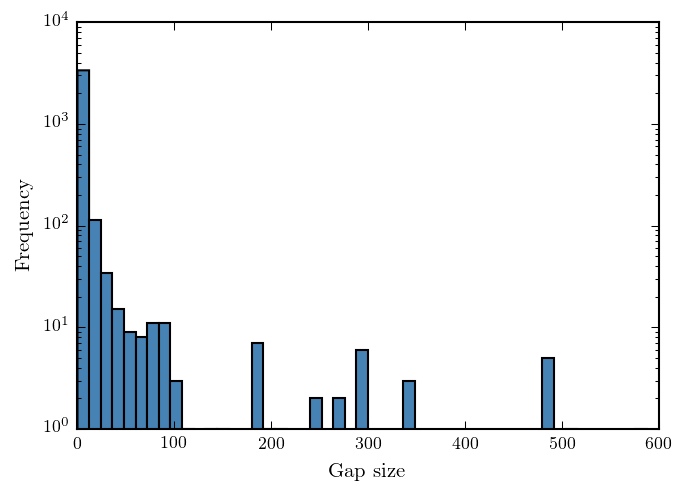

In [9]:
plt.hist(gapSizes, bins=50, range=[0, 600])
plt.yscale("log")
plt.xlabel("Gap size")
plt.ylabel("Frequency")

# Tests

## Single points removed

In [10]:
import glob                                                                                           
tsNames = glob.glob("test_data/intervalLen_200/*.csv")

### Single sensor SSM EM
Looking at a single test dataset

In [11]:
ts = loadTestSets(fullData, "", tsNames[2:3])[0]
YRaw = ts["data"][ts["ti"]:ts["ti"]+ts["intervalLen"], :].T

### Single sensor SSM EM

In [13]:
XHat_SS, sigma_smooth_SS, A_SS, C_SS, Q_SS, R_SS, pi0_SS, sigma0_SS = ssmEM(YRaw[ts["sensor"]:ts["sensor"]+1, :], 1, maxIt=100)
YHat_SS = np.dot(C_SS, XHat_SS)

### Multisensor SSM EM

In [14]:
YRaw = ts["data"][ts["ti"]:ts["ti"]+ts["intervalLen"], :].T
XHat_MS, sigma_smooth_MS, A_MS, C_MS, Q_MS, R_MS, pi0_MS, sigma0_MS = ssmEM(YRaw, 7, maxIt=100)
YHat_MS = np.dot(C_MS, XHat_MS)

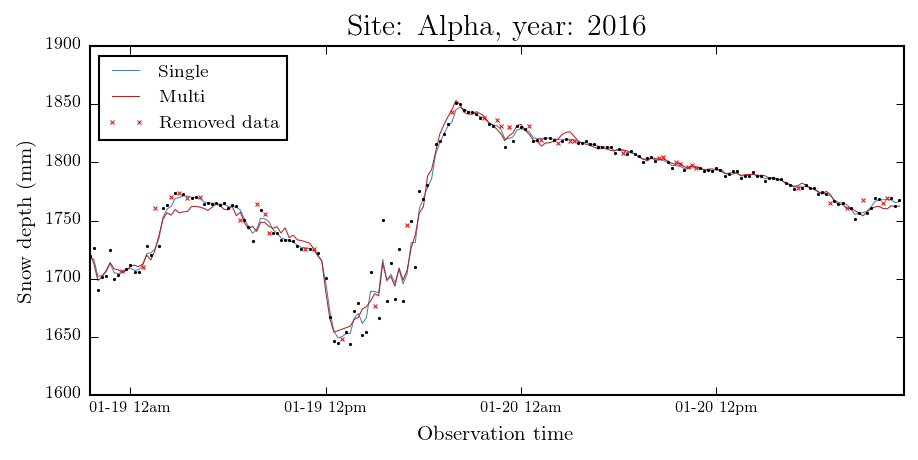

In [16]:
plt.figure(figsize=(7, 3))
sensor = ts["sensor"]

# Plot single sensor result
plt.plot(range(ts["ti"], ts["ti"]+ts["intervalLen"]), YHat_SS.T, linewidth=0.5, label="Single")

# Plot multi sensor result
plt.plot(range(ts["ti"], ts["ti"]+ts["intervalLen"]), YHat_MS[sensor, :], linewidth=0.5, label="Multi")

# Plot series with gaps
plt.plot(range(ts["ti"], ts["ti"]+ts["intervalLen"]), YRaw[sensor, :].T, '.k', markersize=2)

plt.plot(ts["removedTimes"], fullData[ts["removedTimes"], sensor], 'xr', markersize=2, label="Removed data")

plt.legend(loc="upper left")
plt.xlabel("Observation time")
plt.ylabel("Snow depth (mm)")

plt.xticks(*getMidnightNoonIdx(dateTimes, ts["ti"], ts["ti"]+ts["intervalLen"]), fontsize=7)
plt.title("Site: Alpha, year: 2016")

#### Rough estimate of total noise (sum of diagonals of inherent observation covariance and $C R C^T$, the contribution from the state's inherent noise)

In [17]:
np.mean(np.dot(C_MS, np.dot(Q_MS, C_MS.T)).diagonal() + R_MS.diagonal())

82.830886015295306

### MSEs for the test datasets

In [18]:
ssSSMEMMSEs = [] # single sensor
ssmEMMSEs = [] # multisensor

In [94]:
for tsn in tsNames:
    tset = loadTestSets(fullData, "", [tsn])
    
    # Single sensor
    ssSSMEMMSEs.append(testMSE(imputeFn=lambda t: singleSensorSSMEMTestMSEHelper(t, maxIt=100), testSets=tset))
    
    # Multisensor
    ssmEMMSEs.append(testMSE(imputeFn=lambda t: ssmEMTestMSEHelper(t, nLF=7, maxIt=100), testSets=tset))

/usr/local/lib/python2.7/site-packages/scipy/stats/stats.py:3154: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


	sigma_filt[1] is not positive semidefinite
	sigma_filt[1] is not positive semidefinite


LinAlgError: Array must not contain infs or NaNs

In [146]:
print "single", "multi"
#zip(ssSSMEMMSEs, ssmEMMSEs)
print "mean(SE): ", np.mean(ssSSMEMMSEs), np.mean(ssmEMMSEs)
print "std(SE) / sqrt(n): ", np.std(ssSSMEMMSEs) / float(len(ssSSMEMMSEs)), np.std(ssmEMMSEs) / float(len(ssmEMMSEs))

single multi
mean(SE):  122.532761736 113.930382916
std(SE) / sqrt(n):  2.68627417343 2.55447525311


# Gaps removed

In [272]:
import glob
gapTSNames = glob.glob("test_data/intervalLen_200_gapSize_20/*.csv")

In [273]:
ts = loadTestSets(fullData, "", gapTSNames[9:10])[0]
YRaw = ts["data"][ts["ti"]:ts["ti"]+ts["intervalLen"], :].T

In [274]:
print ts["ti"]
print ts["ti"] + ts["intervalLen"]

10846
11046


### Single sensor SSM EM

In [275]:
XHat_SS, sigma_smooth_SS, A_SS, C_SS, Q_SS, R_SS, pi0_SS, sigma0_SS = ssmEM(YRaw[ts["sensor"]:ts["sensor"]+1, :], 1, maxIt=100)
YHat_SS = np.dot(C_SS, XHat_SS)

### Multisensor SSM EM

In [276]:
YRaw = ts["data"][ts["ti"]:ts["ti"]+ts["intervalLen"], :].T
XHat_MS, sigma_smooth_MS, A_MS, C_MS, Q_MS, R_MS, pi0_MS, sigma0_MS = ssmEM(YRaw, 7, maxIt=100)
YHat_MS = np.dot(C_MS, XHat_MS)

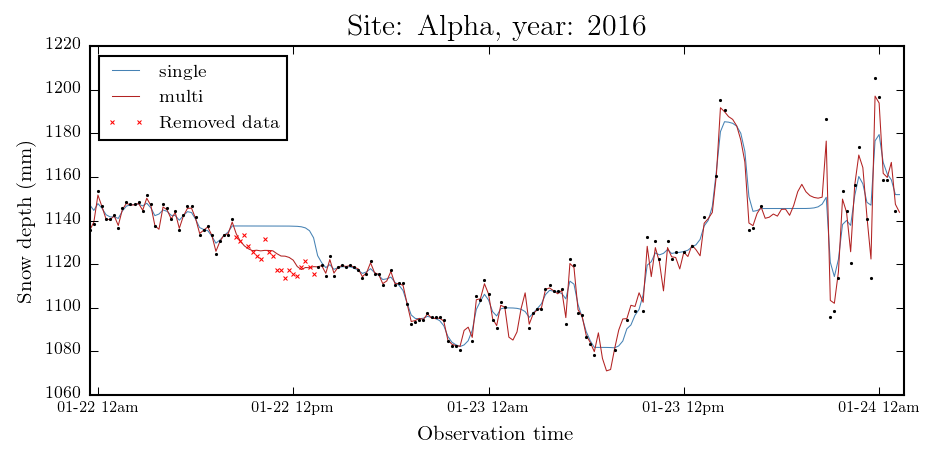

In [278]:
plt.figure(figsize=(7, 3))
sensor = ts["sensor"]

# Plot single sensor result
plt.plot(range(ts["ti"], ts["ti"]+ts["intervalLen"]), YHat_SS.T, linewidth=0.5, label="single")

# Plot multi sensor result
plt.plot(range(ts["ti"], ts["ti"]+ts["intervalLen"]), YHat_MS[sensor, :], linewidth=0.5, label="multi")

# Plot series with gaps
plt.plot(range(ts["ti"], ts["ti"]+ts["intervalLen"]), YRaw[sensor, :].T, '.k', markersize=2)

plt.plot(ts["removedTimes"], fullData[ts["removedTimes"], sensor], 'xr', markersize=2, label="Removed data")

plt.legend(loc="upper left")
plt.xlabel("Observation time")
plt.ylabel("Snow depth (mm)")

plt.xlim(ts["ti"], ts["ti"]+ts["intervalLen"])
plt.xticks(*getMidnightNoonIdx(ts["ti"], ts["ti"]+ts["intervalLen"]), fontsize=7)
plt.title("Site: Alpha, year: 2016")

In [280]:
ts["ti"]

10846

#### Rough estimate of total noise (sum of diagonals of inherent observation covariance and $C R C^T$, the contribution from the state's inherent noise)

In [149]:
np.mean(np.dot(C_MS, np.dot(Q_MS, C_MS.T)).diagonal() + R_MS.diagonal())

177.0896632651

### MSEs for big gaps
done 76:, 0:25,

In [290]:
gapTSNames = glob.glob("test_data/intervalLen_200_gapSize_75/*.csv")

In [291]:
ssSSMEMMSEs_biggaps = [] # single sensor
ssmEMMSEs_biggaps = [] # multisensor

In [ ]:
for tsn in gapTSNames:
    tset = loadTestSets(fullData, "", [tsn])
    
    # Single sensor
    ssSSMEMMSEs_biggaps.append(testMSE(imputeFn=lambda t: singleSensorSSMEMTestMSEHelper(t, maxIt=100), testSets=tset))
    
    # Multisensor
    ssmEMMSEs_biggaps.append(testMSE(imputeFn=lambda t: ssmEMTestMSEHelper(t, nLF=7, maxIt=100), testSets=tset))

In [284]:
print "single: %f +/- %f"%(np.nanmean(ssSSMEMMSEs_biggaps), np.nanstd(ssSSMEMMSEs_biggaps) / float(np.isfinite(ssSSMEMMSEs_biggaps).sum()))
print "multi : %f +/- %f"%(np.nanmean(ssmEMMSEs_biggaps), np.nanstd(ssmEMMSEs_biggaps) / float(np.isfinite(ssmEMMSEs_biggaps).sum()))

single: 425.302634 +/- 18.778307
multi : 222.236404 +/- 12.755190


### MSEs

In [89]:
ssSSMEMMSEs_gaps = [] # single sensor
ssmEMMSEs_gaps = [] # multisensor

In [142]:
for tsn in gapTSNames[76:]:
    tset = loadTestSets(fullData, "", [tsn])
    
    # Single sensor
    ssSSMEMMSEs_gaps.append(testMSE(imputeFn=lambda t: singleSensorSSMEMTestMSEHelper(t, maxIt=100), testSets=tset))
    
    # Multisensor
    ssmEMMSEs_gaps.append(testMSE(imputeFn=lambda t: ssmEMTestMSEHelper(t, nLF=7, maxIt=100), testSets=tset))

In [143]:
print "single: %f +/- %f"%(np.nanmean(ssSSMEMMSEs_gaps), np.nanstd(ssSSMEMMSEs_gaps) / float(np.isfinite(ssSSMEMMSEs_gaps).sum()))
print "multi : %f +/- %f"%(np.nanmean(ssmEMMSEs_gaps), np.nanstd(ssmEMMSEs_gaps) / float(np.isfinite(ssmEMMSEs_gaps).sum()))

single: 370.648568 +/- 8.201292
multi : 218.565184 +/- 6.130548


# Older model comparison

## Test data MSEs for each imputation algorithm

#### Generate test datasets by using the block bootstrap to resample each sensor's data

In [3]:
#_ = genBootstrapData(fullData, ti=0, tf=fullData.shape[0], n=100, blockLen=5)

In [17]:
bsSets = loadBootstrapData(dirName="bootstrap_data/")

#### Run 3rd generation DFM estimator on bootstrap datasets. MSE: ~484 +/- 4

In [ ]:
dfmThirdGenMSEs = []

# Run imputer on each bootstrapped dataset
for bss in bsSets:
    dfmThirdGenMSEs.append(testMSE(imputeFn=lambda ts: dfmThirdGenTestMSEHelper(ts, nLF=2), testSets=loadTestSets(bss, dirName="test_data/")))

In [20]:
print "Third generation DFM. Test dataset MSE = ~%f +/- %f"%(np.mean(dfmThirdGenMSEs), np.std(dfmThirdGenMSEs) / np.sqrt(len(dfmThirdGenMSEs)))

Third generation DFM. Test dataset MSE = ~484.274036 +/- 4.200070


#### Run state space EM on bootstrap datasets. MSE: 

In [ ]:
ssmEMMSEs = []

# Run imputer on each bootstrapped dataset
for bss in bsSets:
    ssmEMMSEs.append(testMSE(imputeFn=lambda ts: ssmEMTestMSEHelper(ts, nLF=2), testSets=loadTestSets(bss, dirName="test_data/")))

In [ ]:
print "SSM EM. Test dataset MSE = ~%f +/- %f"%(np.mean(ssmEMMSEs), np.std(ssmEMMSEs) / np.sqrt(len(ssmEMMSEs)))

In [13]:
import subprocess
subprocess.call(["echo", "\a"])

0

#### Run Kalman filter on bootstrap datasets. MSE: ~386 +/- 3

In [ ]:
kfMSEs = []

# Run imputer on each bootstrapped dataset
for bss in bsSets:
    kfMSEs.append(testMSE(imputeFn=lambda ts: kalmanTestMSEHelper(ts, smooth=False), testSets=loadTestSets(bss, dirName="test_data/")))

In [ ]:
print "Kalman filter. Test dataset MSE = ~%f +/- %f"%(np.mean(kfMSEs), np.std(kfMSEs) / np.sqrt(len(kfMSEs)))

#### Run Kalman smoother on bootstrap datasets. MSE: ~240 +/- 3

In [ ]:
#ksMSEs = []

# Run imputer on each bootstrapped dataset
for i, bss in enumerate(bsSets[20:30]):
    ksMSEs.append(testMSE(imputeFn=lambda ts: kalmanTestMSEHelper(ts, smooth=True), testSets=loadTestSets(bss, dirName="test_data/")))
    print "Imputed for set %i. MSE = %f"%(i, ksMSEs[-1])

In [13]:
print "Kalman smoother. Test dataset MSE = ~%f +/- %f"%(np.mean(ksMSEs), np.std(ksMSEs) / np.sqrt(len(ksMSEs)))

Kalman smoother. Test dataset MSE = ~240.751376 +/- 3.472747


#### Run Zeshi's imputer on bootstrap datasets. MSE: ~352 +/- 2 (Note: this is basically DINEOF with n_pc = 1.)

In [25]:
zMSEs = []

# Run imputer on each bootstrapped dataset
for bss in bsSets:
    zMSEs.append(testMSE(imputeFn=lambda t: zeshiImputerTestMSEHelper(t, n_pc=1), testSets=loadTestSets(bss, dirName="test_data/")))

In [26]:
print "Zeshi's algorithm. Test dataset MSE = ~%f +/- %f"%(np.mean(zMSEs), np.std(zMSEs) / np.sqrt(len(zMSEs)))

Zeshi's algorithm. Test dataset MSE = ~351.556452 +/- 2.240686


#### Run DINEOF algorithm on bootstrap datasets. MSE: ~344 +/- 13

In [ ]:
#dineofMSEs = []

# Run imputer on each bootstrapped dataset
for i, bss in enumerate(bsSets[30:50]):
    dineofMSEs.append(testMSE(imputeFn=dineofTestMSEHelper, testSets=loadTestSets(bss, dirName="test_data/")))
    print "Imputed for set %i"%i

In [12]:
print "DINEOF. Test dataset MSE = ~%f +/- %f"%(np.mean(dineofMSEs), np.std(dineofMSEs) / np.sqrt(len(dineofMSEs)))

DINEOF. Test dataset MSE = ~344.242770 +/- 12.538406


#### Run latent factor filter on bootstrap datasets. MSE on first 50 bootstrap datasets: ~199 +/- 4

In [ ]:
lfiMSEs = []

# Run imputer on each bootstrapped dataset
for bss in bsSets[30:50]:
    lfiMSEs.append(testMSE(imputeFn=lfiTestMSEHelper, testSets=loadTestSets(bss, dirName="test_data/")))

Utilities.py:107: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if stds == None:


In [20]:
print "Latent factor filter. Test dataset MSE = ~%f +/- %f"%(np.mean(lfiMSEs), np.std(lfiMSEs) / np.sqrt(len(lfiMSEs)))

Latent factor filter. Test dataset MSE = ~199.085237 +/- 3.822152


#### Run latent smoother filter on bootstrap datasets. MSE: 

In [11]:
lfiSMSEs = []

# Run imputer on each bootstrapped dataset
for bss in bsSets[0:5]:
    lfiSMSEs.append(testMSE(imputeFn=lfiSmootherTestMSEHelper, testSets=loadTestSets(bss, dirName="test_data/")))

In [12]:
print "Latent factor smoother. Test dataset MSE = ~%f +/- %f"%(np.mean(lfiSMSEs), np.std(lfiSMSEs) / np.sqrt(len(lfiSMSEs)))

Latent factor smoother. Test dataset MSE = ~nan +/- nan


## Visually compare imputation methods using a test dataset

In [5]:
testSets = loadTestSets(fullData=fullData, dirName="test_data/intervalLen_300/")
testSet = testSets[1]
ti = testSet["ti"]
tf = ti + testSet["intervalLen"]
sensor = testSet["sensor"]

In [22]:
lfiImputed = lfiTestMSEHelper(testSet)

lfMSE = testMSE(imputeFn=lambda ts: lfiTestMSEHelper(ts, beta=0.0), testSets=[testSet])

In [ ]:
kfImputed = kalmanTestMSEHelper(testSet, smooth=False)

kfMSE = testMSE(imputeFn=lambda ts: kalmanTestMSEHelper(ts, smooth=False), testSets=[testSet])

In [ ]:
ksImputed = kalmanTestMSEHelper(testSet, smooth=True)

ksMSE = testMSE(imputeFn=lambda ts: kalmanTestMSEHelper(ts, smooth=True), testSets=[testSet])

In [25]:
dineofImputed = dineofTestMSEHelper(testSet)

dineofMSE = testMSE(imputeFn=dineofTestMSEHelper, testSets=[testSet])

In [26]:
dfmThirdGenImputed = dfmThirdGenTestMSEHelper(testSet, nLF=2)

dfmThirdGenMSE = testMSE(imputeFn=lambda ts: dfmThirdGenTestMSEHelper(ts, nLF=2), testSets=[testSet])

YHat.shape = (8, 300)
YHat.shape = (8, 300)


In [27]:
print "Third gen DFM MSE = %f"%dfmThirdGenMSE

Third gen DFM MSE = 154.347382


In [54]:
print "Latent factor filter MSE = %f" % lfMSE
print "DINEOF MSE = %f" % dineofMSE
print "Kalman filter MSE = %f" % kfMSE
print "Kalman smoother MSE = %f" % ksMSE

Latent factor filter MSE = 105.829453
DINEOF MSE = 421.107443
Kalman filter MSE = 178.130378
Kalman smoother MSE = 179.837210


In [75]:
print ti, tf

13766 14066


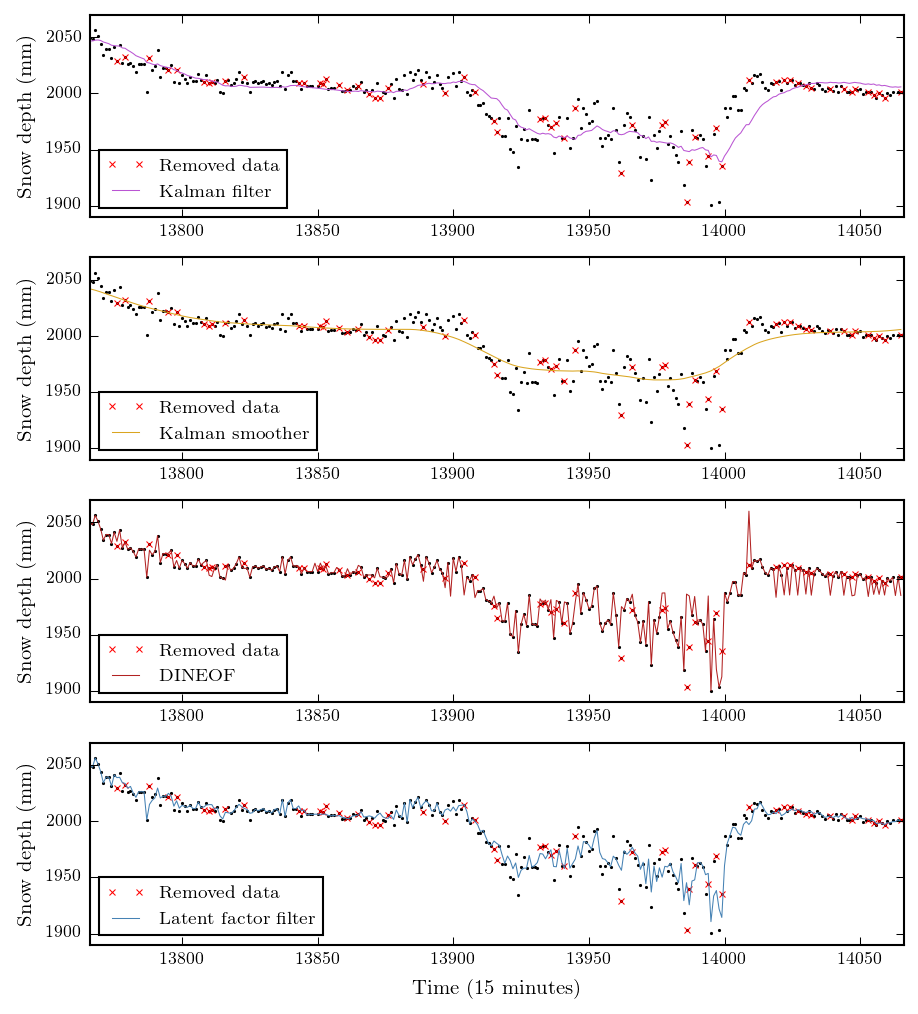

In [102]:
fig = plt.figure(figsize=(7, 8))

# Imputed results and labels
impResults = [kfImputed, ksImputed, dineofImputed, lfiImputed]
impLabels = ["Kalman filter", "Kalman smoother", "DINEOF", "Latent factor filter"]
colors = ['mediumorchid', 'goldenrod', 'firebrick', 'steelblue'] #c["color"] for c in plt.rcParams["axes.prop_cycle"]]

for i, (imp, label, color) in enumerate(zip(impResults, impLabels, colors)):
    ax = fig.add_subplot(len(impResults), 1, i+1)
    
    # Plot datapoints
    ax.plot(range(ti, tf), df_cleaned.values[ti:tf, sensor], '.k', markersize=2) # true data
    ax.plot(testSet["removedTimes"], df_cleaned.values[testSet["removedTimes"], sensor], 'xr', markersize=3, label="Removed data") # removed data
    
    # Plot imputed values
    ax.plot(range(ti, tf), imp[ti:tf, sensor], linewidth=0.5, color=color, label=label)
    
    # Make plot pretty
    ax.set_ylabel("Snow depth (mm)")
    ax.set_xlim(ti, tf)
    ax.set_ylim(1890, 2070)
    ax.legend(loc="lower left")
    
    if i == len(impResults) - 1:
        ax.set_xlabel("Time (15 minutes)")
#    if i == 0:
#        ax.set_title("Imputation comparison for sensor %i"%sensor)

In [90]:
colors

['steelblue',
 'firebrick',
 'goldenrod',
 'mediumorchid',
 'teal',
 'darkslateblue',
 'DarkSalmon',
 'LightSkyBlue',
 'Navy',
 'Peru']

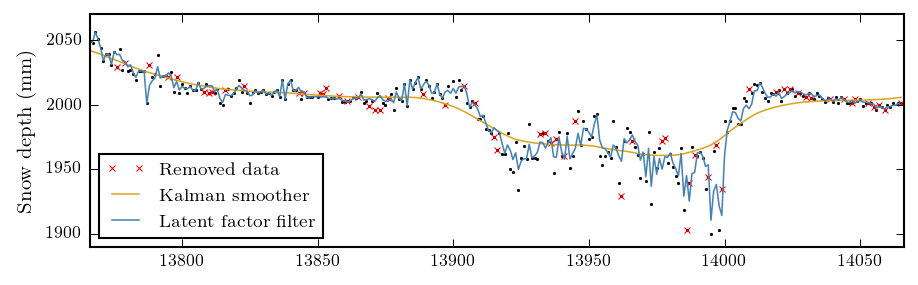

In [98]:
# Overlay Kalman smoother and LFF results
fig = plt.figure(figsize=(7, 2))
ax = fig.add_subplot(1, 1, 1)

# Plot datapoints
ax.plot(range(ti, tf), df_cleaned.values[ti:tf, sensor], '.k', markersize=2) # true data
ax.plot(testSet["removedTimes"], df_cleaned.values[testSet["removedTimes"], sensor], 'xr', markersize=3, label="Removed data") # removed data
    
for i, (imp, label, color) in enumerate(zip([ksImputed, lfiImputed],
                                            ["Kalman smoother", "Latent factor filter"],
                                            ["goldenrod", "steelblue"])):
    # Plot imputed values
    ax.plot(range(ti, tf), imp[ti:tf, sensor], linewidth=0.75, color=color, label=label)
    
    # Make plot pretty
    ax.set_ylabel("Snow depth (mm)")
    ax.set_xlim(ti, tf)
    ax.set_ylim(1890, 2070)
    ax.legend(loc="lower left")
    
    if i == len(impResults) - 1:
        ax.set_xlabel("Time (15 minutes)")
#    if i == 0:
#        ax.set_title("Imputation comparison for sensor %i"%sensor)

## Testing latent factor smoother

In [4]:
lfiSImputed = lfiSmootherTestMSEHelper(testSet)

lfSMSE = testMSE(imputeFn=lfiSmootherTestMSEHelper, testSets=[testSet])

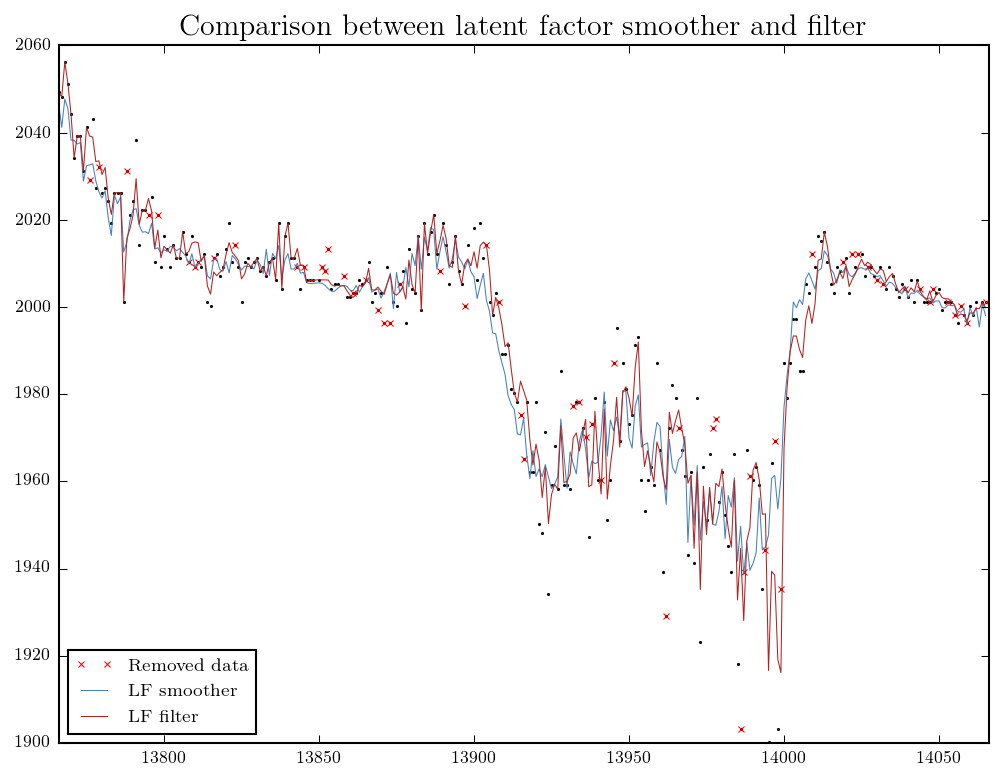

In [6]:
# Plot datapoints
plt.figure(figsize=(8, 6))
plt.plot(range(ti, tf), df_cleaned.values[ti:tf, sensor], '.k', markersize=2) # true data
plt.plot(testSet["removedTimes"], df_cleaned.values[testSet["removedTimes"], sensor], 'xr', markersize=3, label="Removed data") # removed data
plt.plot(range(ti, tf), lfiSImputed[ti:tf, sensor], linewidth=0.5, label="LF smoother")
plt.plot(range(ti, tf), lfiImputed[ti:tf, sensor], linewidth=0.5, label="LF filter")

plt.xlim(ti, tf)
plt.legend(loc="lower left")

plt.title("Comparison between latent factor smoother and filter")

### Examining Kalman filter

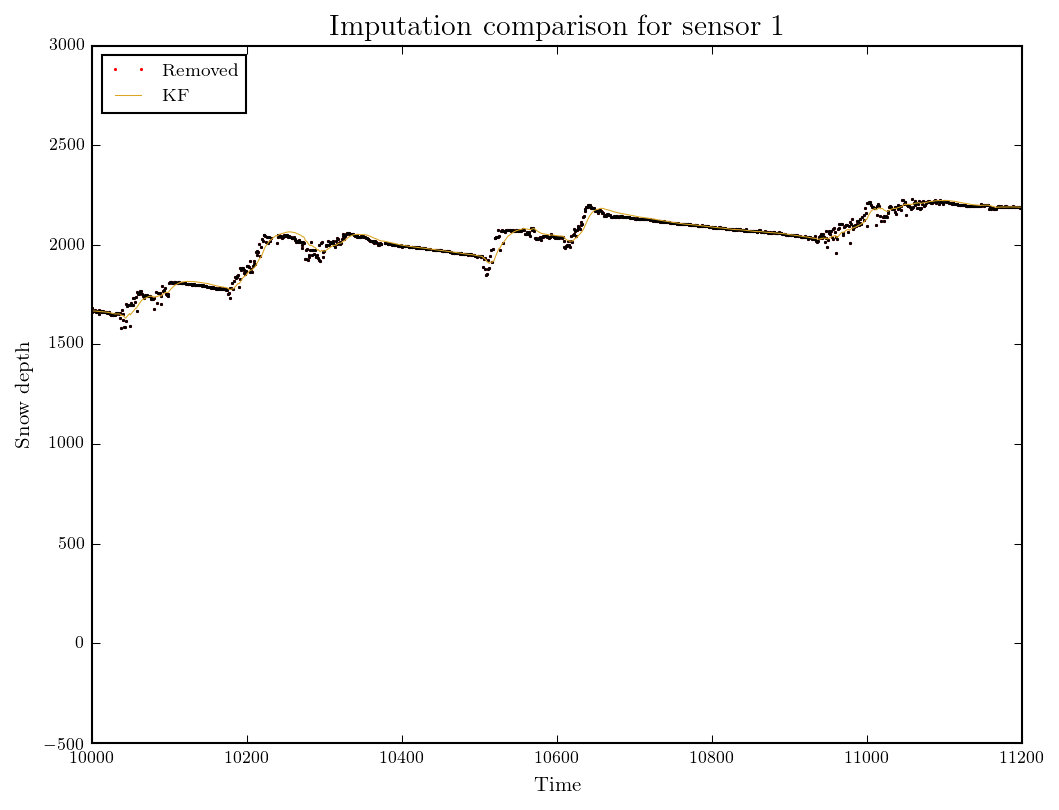

In [33]:
plt.figure(figsize=(8, 6))

plt.plot(df_cleaned.values[:, sensor], '.r', markersize=2, label="Removed") # true data
plt.plot(testSet["data"][:, sensor], '.k', markersize=2) # test data
plt.plot(kfImputed[:, sensor], linewidth=0.5, color="goldenrod", label="KF") # Kalman filter result

plt.xlabel("Time")
plt.ylabel("Snow depth")
plt.title("Imputation comparison for sensor %i"%sensor)

plt.xlim(10000, 11200)

plt.legend(loc="upper left")

In [35]:
from kalman import FilterSnowdepth, EstimateObservationNoise

In [36]:
series = df_cleaned.values[:, 1]

In [37]:
mus, sigmas = FilterSnowdepth(series, obs_noise=EstimateObservationNoise(series), system_noise=np.diag((1e0,1e-2,1e-3)), outlier_threhold=2e3)

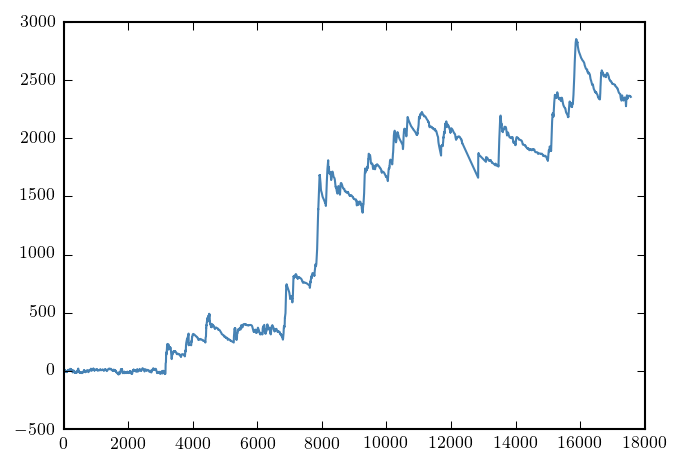

In [43]:
plt.plot(mus[:, 2] - mus[:, 0])

(10000, 11200)

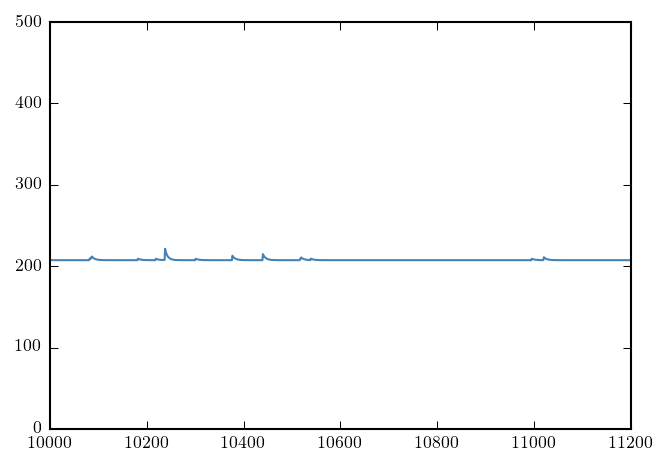

In [46]:
plt.plot(sigmas)
plt.ylim(0, 500)

plt.xlim(10000, 11200)

In [47]:
sigmas

array([ 188.64118197,  250.26718197,  237.65960736, ...,  207.35298708,
        207.35298708,  207.35298708])

### Visually check bootstrap datasets

In [4]:
bsSets = genBootstrapData(fullData, ti=0, tf=fullData.shape[0], n=5, blockLen=5)

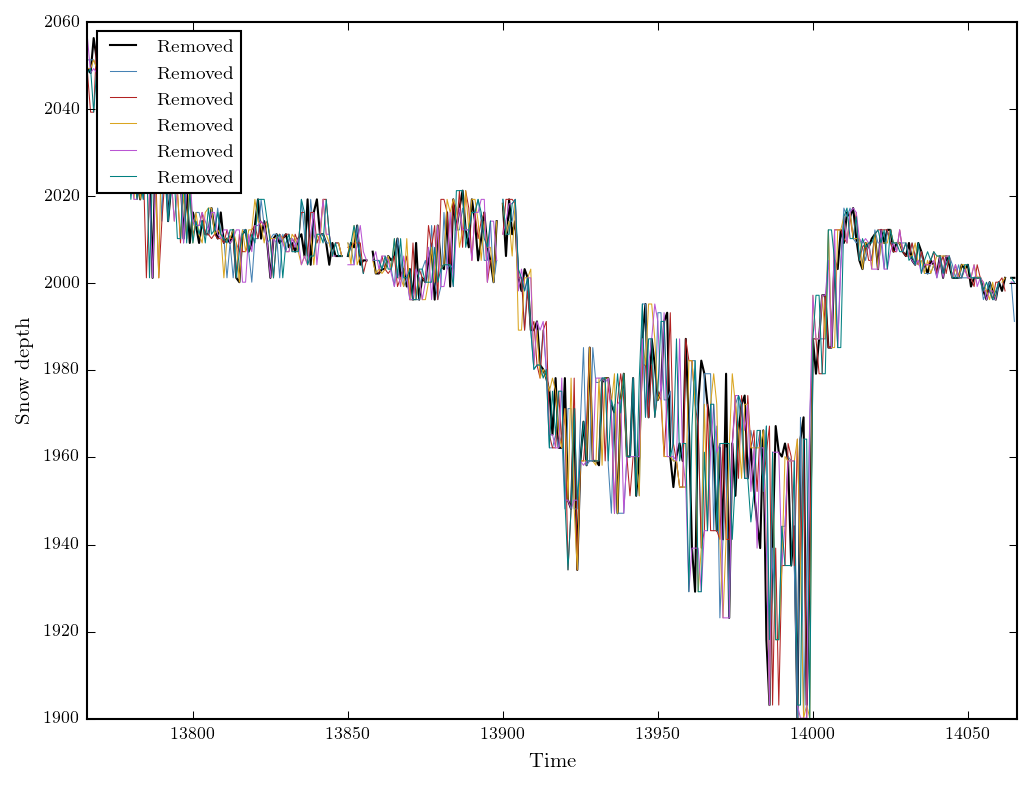

In [5]:
plt.figure(figsize=(8, 6))

plt.plot(range(13766, 14066), fullData[13766:14066, 1], 'black', linewidth=1, label="Removed") # true data

for bsSet in bsSets:
    plt.plot(range(13766, 14066), bsSet[13766:14066, 1], linewidth=0.5, label="Removed") # true data

plt.xlabel("Time")
plt.ylabel("Snow depth")
plt.xlim(13766, 14066)

plt.legend(loc="upper left")

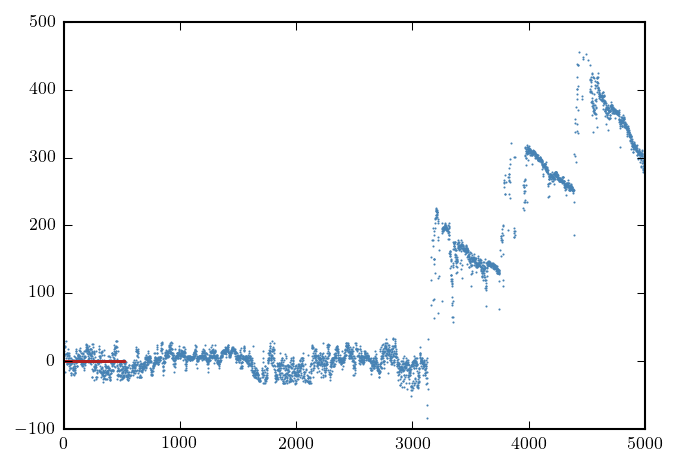

In [74]:
plt.plot(fullData[0:5000, 1], '.', markersize=1)
plt.plot(np.nan_to_num(fullData[np.where(np.isnan(fullData[0:5000, 1]))[0], 1]), '.', markersize=1)

In [85]:
y = df_cleaned['snowdepth_1'].values[2000:3000]

In [ ]:
np.where(~np.isnan(y))[0]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        80,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
        94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106,
       107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
       120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
       133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
       146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
       159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
       172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 18